# Performing a Cluster Analysis

One-Trick-Pony :D

Basically clustering the issues, by people working on them and commenting on them, as well as priority and date of creation. Maybe this will reconstruct what different aspects Zookeeper has (e.g. Server development, client-side, User-Interface etc.)

In [31]:
import pymongo
from pymongo import MongoClient

import pandas as pd
import numpy as np
import scipy as sp
import sklearn as sk
import matplotlib 
from matplotlib import pyplot as plt
plt.style.use('seaborn-darkgrid')
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

client = MongoClient('localhost', 27017)
db = client.smartshark_test

In [32]:
events = pd.DataFrame(list(db.event.find()))
issues = pd.DataFrame(list(db.issue.find()))
authors = pd.DataFrame(list(db.people.find()))
comments = pd.DataFrame(list(db['issue_comment'].find()))


comments.author_id = comments.author_id.astype('string')
comments.issue_id = comments.issue_id.astype('string')
authors._id = authors._id.astype('string')
issues._id = issues._id.astype('string')
issues.priority = issues.priority.fillna('nan',inplace=False)
events.issue_id = events.issue_id.astype('string')
events.author_id = events.author_id.astype('string')

cmap = {'Trivial':'green', 'Minor':'yellow', 'Major':'orange', 'Critical':'red', 'Blocker':'grey', 'nan':'white'}


# Making contributing author vectors

In [33]:
empty_author_vector = pd.DataFrame(index=authors._id, columns=['is_there'])
empty_author_vector['is_there']=0

In [34]:
def get_comment_author_vector(issue_id):
    comment_authors_to_issue = comments[comments.issue_id == issue_id].author_id
    comment_author_vector = empty_author_vector.copy()
    if list(comment_authors_to_issue):
        comment_author_vector.loc[list(comment_authors_to_issue)] = 1
    return comment_author_vector

In [35]:
def get_event_author_vector(issue_id):
    event_authors_to_issue = events[events.issue_id == issue_id].author_id
    event_author_vector = empty_author_vector.copy()
    if list(event_authors_to_issue):
        event_author_vector.loc[list(event_authors_to_issue)] = 1
    return event_author_vector   

## Making the priority vectors

In [36]:
def get_priority_vector(issue_id):
    priority_vector_dict = {
        'Trivial':[1,0,0,0,0,0], 
        'Minor':[0,1,0,0,0,0], 
        'Major':[0,0,1,0,0,0], 
        'Critical':[0,0,0,1,0,0], 
        'Blocker':[0,0,0,0,1,0], 
        'nan':[0,0,0,0,0,1]
    }
    return np.array(priority_vector_dict[issues.priority[issues._id==issue_id].iloc[0] ])

## Ignoring the Time for now

In [37]:
issue_sample = issues._id.dropna().sample(1000)
issue_test = issue_sample.iloc[600:]
issue_train = issue_sample.iloc[:600]

In [38]:
list_of_vectors = [
    np.append(
        np.append(
            get_comment_author_vector(issue_id), get_event_author_vector(issue_id)
        ), 
        get_priority_vector(issue_id))
for issue_id in issue_train]

In [40]:
list_of_test_vectors = [
    np.append(
        np.append(
            get_comment_author_vector(issue_id), get_event_author_vector(issue_id)
        ), 
        get_priority_vector(issue_id))
for issue_id in issue_test]

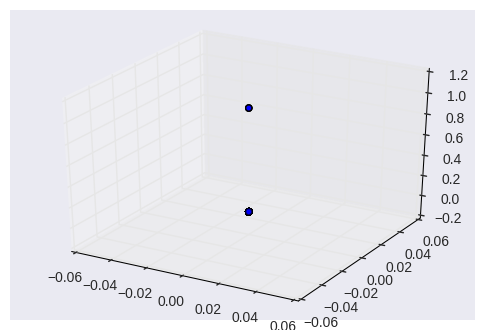

In [41]:
plt.close('all')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(np.array(list_of_vectors)[:,0], np.array(list_of_vectors)[:,1], np.array(list_of_vectors)[:,2]) 

# The first FUN-Part: PCA

In [42]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [43]:
pca = PCA(n_components=0.95)
pca.fit(list_of_vectors)

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [44]:
X = pca.transform(list_of_vectors)

In [45]:
X = np.array(X)

In [46]:
X

array([[  1.39764916e+00,  -4.41556252e-01,  -7.71196195e-01, ...,
          7.80625564e-18,   1.65557672e-16,   3.62123526e-17],
       [ -5.07636697e-01,   1.22023767e+00,   7.01963538e-01, ...,
         -2.46927045e-16,   8.56519716e-18,  -5.32505897e-16],
       [  9.02836814e-01,  -2.41146465e-01,   1.24148254e+00, ...,
          1.79869140e-16,   4.35664959e-15,  -2.47718512e-15],
       ..., 
       [  1.10553361e+00,   4.29533498e-01,  -8.65908934e-01, ...,
         -3.40276852e-15,  -4.81700183e-15,   1.19826024e-15],
       [ -1.67994438e-01,   3.93510911e-02,  -1.23858394e-01, ...,
         -4.53304928e-16,  -3.81639165e-17,   3.80771803e-16],
       [ -2.49049109e-01,  -6.53008658e-01,  -2.73897748e-01, ...,
         -2.45029691e-17,   1.29562160e-16,   9.58434720e-17]])

In [47]:
icount=0

(0, 1, 2)


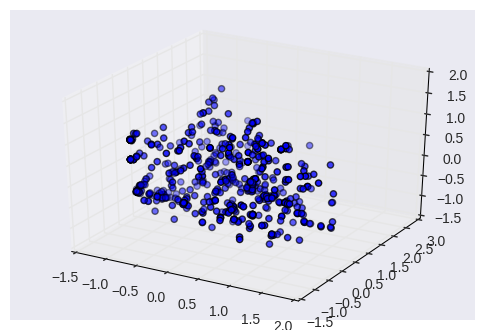

In [48]:
plt.close('all')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:,(icount + 0)%13], X[:,(icount + 1)%13], X[:,(icount + 2)%13])
print(icount, icount+1, icount+2)
icount+=1

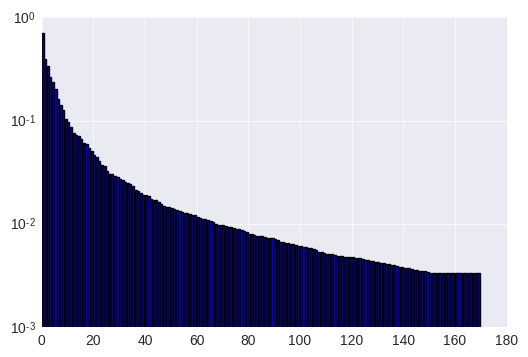

In [49]:
plt.close('all')
plt.bar(np.arange(len(pca.components_)), pca.explained_variance_)
plt.yscale('log')

<Container object of 170 artists>

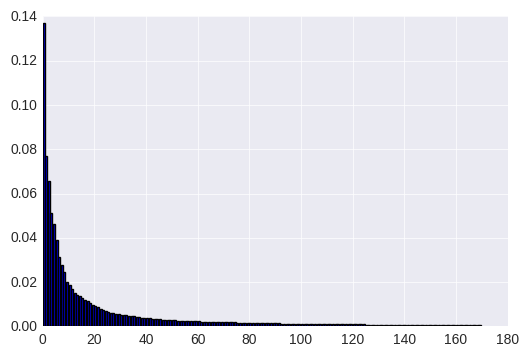

In [50]:
plt.close('all')
plt.bar(np.arange(len(pca.components_)),pca.explained_variance_ratio_)
#plt.yscale('log')

In [51]:
total_vector_index = empty_author_vector.append(empty_author_vector).append(pd.DataFrame(index=['Trivial', 'Minor','Major','Critical','Blocker','nan'], columns=['is_there']))

In [52]:
total_vector_names = total_vector_index.copy()
total_vector_names.index = [authors[authors._id==ind].username.iloc[0] if ind not in ['Trivial', 'Minor','Major','Critical','Blocker','nan'] else ind for ind in total_vector_names.index ]

In [53]:
principal_components = pd.DataFrame(index = total_vector_names.index, columns=range(1,14))

In [54]:
for i in range(len(pca.components_[:13])):
    principal_components[i+1]=pca.components_[i]

In [149]:
principal_components.sort_values(by=1, ascending=False).head(5)

,1,2,3,4,5,6,7,8,9,10,11,12,13
phunt,0.476924,-0.111657,0.038398,-0.275188,0.294604,0.095160,0.024554,-0.016446,0.061937,0.116238,0.004885,-0.159299,-0.093641
phunt,0.416040,-0.153468,0.059088,-0.398130,0.431744,0.036170,0.031325,0.131208,0.081250,-0.149225,0.050096,0.154027,-0.013387
mahadev,0.392760,-0.203491,0.009675,0.315340,-0.330894,0.232502,-0.161355,0.094210,0.033334,0.056210,0.118249,0.124761,0.121426
mahadev,0.376857,-0.189378,0.042517,0.323025,-0.273729,0.128231,-0.241236,0.081847,0.088874,-0.000635,0.026708,-0.036500,-0.307701
hudson,0.371398,0.293777,0.060538,-0.036022,-0.193319,-0.527521,-0.123391,-0.397545,0.312161,-0.091699,-0.111149,0.037653,0.298791


In [151]:
principal_components.sort_values(by=2, ascending=True).head(5)

,1,2,3,4,5,6,7,8,9,10,11,12,13
mahadev,0.392760,-0.203491,0.009675,0.315340,-0.330894,0.232502,-0.161355,0.094210,0.033334,0.056210,0.118249,0.124761,0.121426
mahadev,0.376857,-0.189378,0.042517,0.323025,-0.273729,0.128231,-0.241236,0.081847,0.088874,-0.000635,0.026708,-0.036500,-0.307701
phunt,0.416040,-0.153468,0.059088,-0.398130,0.431744,0.036170,0.031325,0.131208,0.081250,-0.149225,0.050096,0.154027,-0.013387
phunt,0.476924,-0.111657,0.038398,-0.275188,0.294604,0.095160,0.024554,-0.016446,0.061937,0.116238,0.004885,-0.159299,-0.093641
breed,0.139400,-0.052056,-0.158242,0.194064,-0.025014,-0.221759,0.527288,0.129869,-0.044087,0.131129,-0.039314,0.046174,-0.018566


In [154]:
important_people = principal_components.abs().sum(axis=1)

In [157]:
important_people.sort_values(ascending=False)

hudson                         2.854964
hadoopqa                       2.442695
Minor                          2.373279
mahadev                        2.194207
michi                          2.148681
Major                          2.140808
mahadev                        2.117238
phunt                          2.105159
cnauroth                       2.022139
fpj                            2.008578
rgs                            1.959138
fpj                            1.948756
michi                          1.937770
breed                          1.883409
phunt                          1.768931
breed                          1.726961
rakeshr.radhakrishnan.potty    1.637101
rakeshr.radhakrishnan.potty    1.548188
Critical                       1.500785
camille                        1.455436
Blocker                        1.346787
rgs                            1.274836
camille                        0.975376
shralex                        0.881215
thomas                         0.832129


<IPython.core.display.Javascript object>


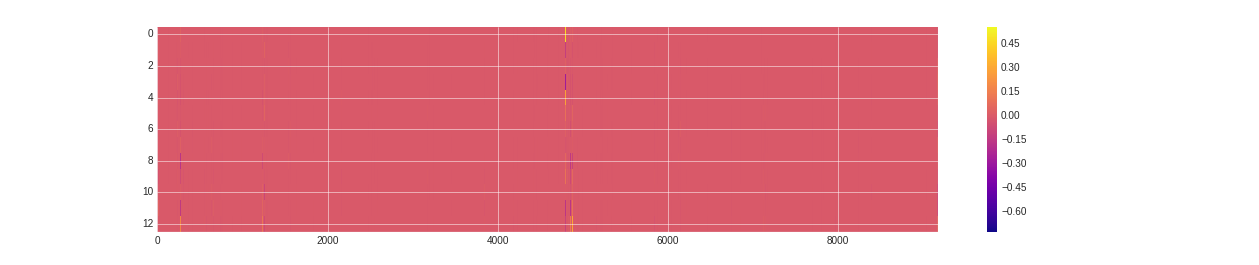

In [152]:
plt.close('all')
plt.imshow(pca.components_[:13], cmap='plasma', aspect='auto', interpolation='None')
plt.colorbar()


# HAHA Only 13 dimensions left nice!!

In [122]:
plt.close('all')
ncls=[]
scores=[]
for ncl in range(2,20):
    model = KMeans(n_clusters=ncl)
    model.fit(X)
    ncls.append(ncl)
    scores.append(model.score(X))
    print('ncl: {}, score: {}'.format(ncl,model.score(X)))

ncl: 2, score: -2607.7544767
ncl: 3, score: -2456.53093988
ncl: 4, score: -2341.31980063
ncl: 5, score: -2263.22189162
ncl: 6, score: -2200.07761554
ncl: 7, score: -2140.06577098
ncl: 8, score: -2088.14923789
ncl: 9, score: -2060.33708319
ncl: 10, score: -2030.84124639
ncl: 11, score: -2001.36021572
ncl: 12, score: -1954.81880365
ncl: 13, score: -1954.97030158
ncl: 14, score: -1932.08313884
ncl: 15, score: -1897.37994006
ncl: 16, score: -1878.22146473
ncl: 17, score: -1865.1725796
ncl: 18, score: -1855.93803655
ncl: 19, score: -1818.07643568


<IPython.core.display.Javascript object>


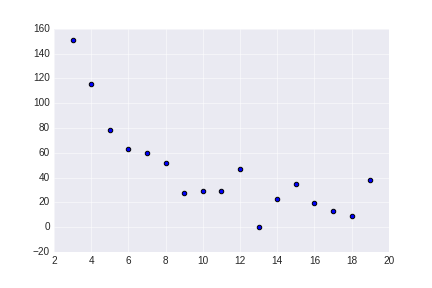

In [124]:
plt.scatter(ncls[1:], np.array(scores[1:])-np.array(scores[:-1]) )

In [127]:
model = KMeans(9)
model.fit(X)
model.score(X)

-2054.4542299524023

### Validation

In [128]:
Y = pca.transform(list_of_test_vectors)

In [129]:
model.score(Y)

-1176.7858940355841

In [130]:
%matplotlib notebook

In [131]:
icount=0

<IPython.core.display.Javascript object>


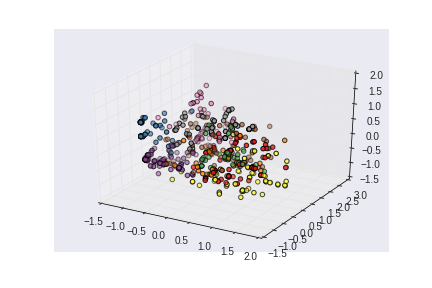

(0, 1, 2)


In [132]:
plt.close('all')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:,(icount + 0)%13], X[:,(icount + 1)%13], X[:,(icount + 2)%13], c=model.labels_, cmap='Set1')
print(icount, icount+1, icount+2)
icount+=1

In [98]:
from sklearn.cluster import AgglomerativeClustering

In [99]:
model_agglo = AgglomerativeClustering(n_clusters=13)
labels_agglo = model_agglo.fit_predict(X)

In [104]:
%matplotlib notebook

<IPython.core.display.Javascript object>


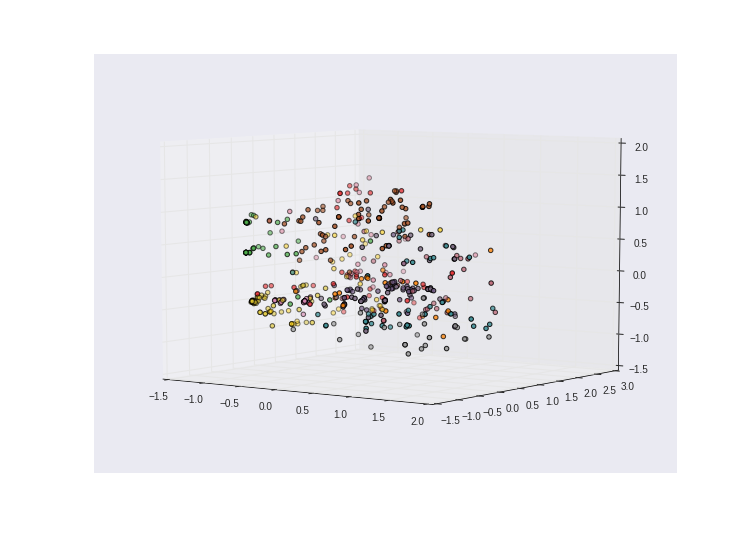

(0, 1, 2)


In [105]:
icount=0
plt.close('all')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:,(icount + 0)%13], X[:,(icount + 1)%13], X[:,(icount + 2)%13], c=labels_agglo, cmap='Set1')
print(icount, icount+1, icount+2)